# Instruments and Catalogue matching

Requested ingredients:
* fits file of a known instrument (sdss, hst, ptf, stella) having a wcs solution
* an internet connection (for the 'download_catalogue' method)

## Instrument vs. Image

An instrument has several additional functionalities in comparison to an Image.
* fundatental parameters:
   * bandname (enabling bandpass and lbda)
   * mab0 (zeropoint of the instrument)
   * _dataunits_to_election (that enables aperture photometry using sep).


**Remark**: 'Instrument' inherite from 'Image'. 

**Code Construction**: The mother class is 'Image', then a basic 'BaseInstrument' is defined that structures the future individual instruments: 'SDSS', 'HST' etc that all are classes inheriting 'BaseInstrument' (i.e. grand child of Image). 

**Info** the list of known instrument is recorded in astrobject.astrobject.instruments.instrument.KNOWN_INSTRUMENTS

In [1]:
# no annoying warnings
#import warnings
#warnings.filterwarnings('ignore')
# Astrobject module
import numpy as np
# plot within the notebook
%matplotlib notebook
import matplotlib.pyplot as mpl

In [2]:
from astrobject.instruments import get_instrument 

## Load the Instrument. Easy

Load the instrument, here the "sdss" object

In [102]:
sdss = get_instrument("data/sdss_PTF10qjq_i.fits")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


The visualisation is the same as for Image (same method inherated)

<IPython.core.display.Javascript object>


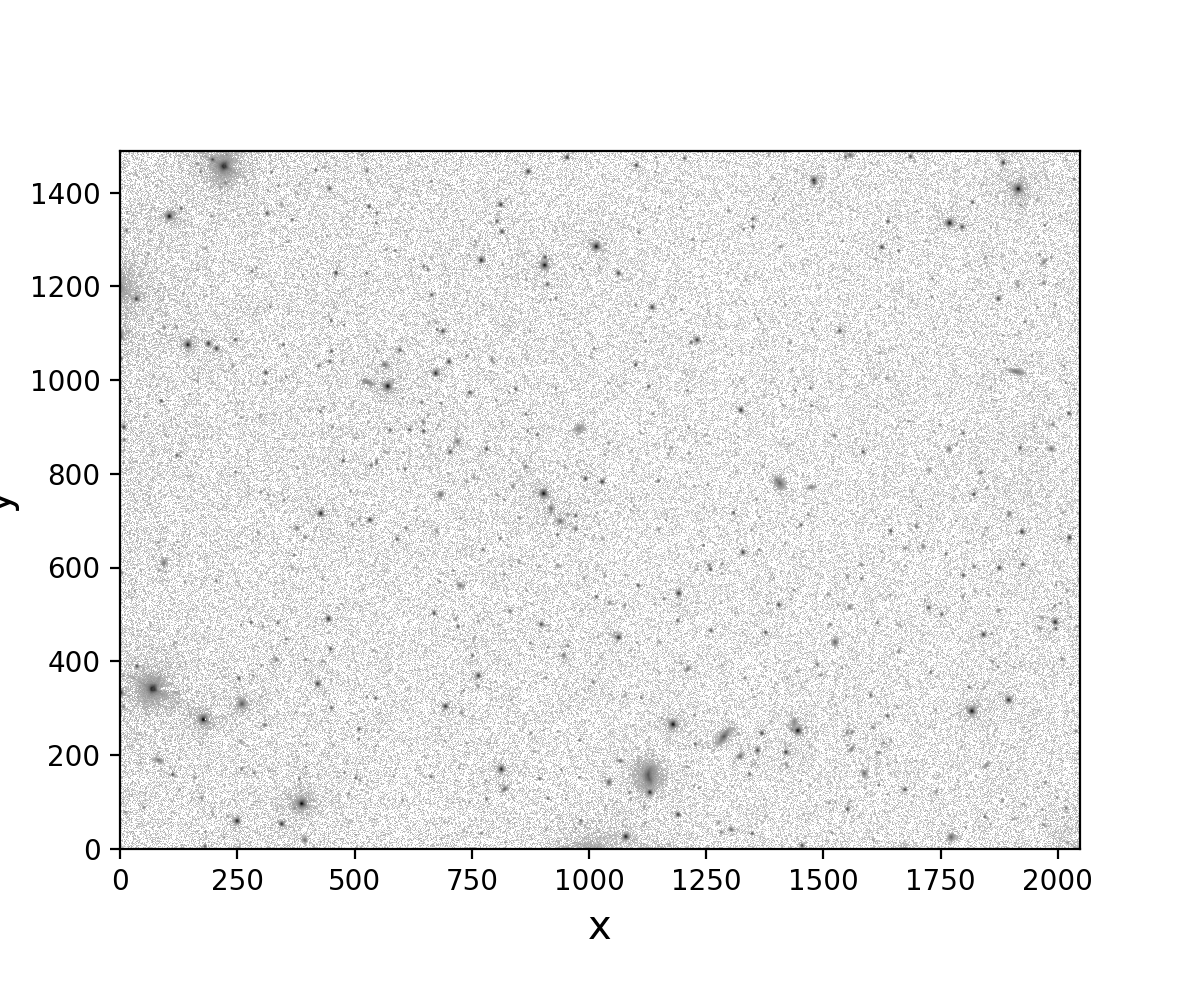

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/photometry.py:1277: RuntimeWarning: invalid value encountered in log10
  x = np.log10(valuetoshow) if logscale else valuetoshow


In [103]:
pl = sdss.show()

In [5]:
sdss.sepobjects

## Load a catalogue for the image's field of view

If you have access to internet, the download_catalogue() methods enables you to directly query for the catalogue associated to your image. 
When you do so, you can specify the catalogue properties:
Catalogue arguments:

* source: The origin of the catalogue (SDSS/WISE/2MASS)
* column_filters: a dictionnary selecting the catalogue sources. For instance, if you want the sdss sources that have a magnitude range in the g-band between 13 and 22: column_filters={"gmag":"13..22"}. **Important, SDSS** catalogue have default column_filters: 
  - "mode" must be 1 (primary=latest release), 
  - "q_mode" is "+" means photometry condition,
  - "Q" in [2,3] (acceptable and good) [see vizier](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=V/139)

**Remark** This functionnality is also accessible from an 'image' object.

In [104]:
from astroquery import vizier
from astropy.coordinates import SkyCoord, Angle
from astropy import units

In [105]:
sdss.sep_extract()

<IPython.core.display.Javascript object>


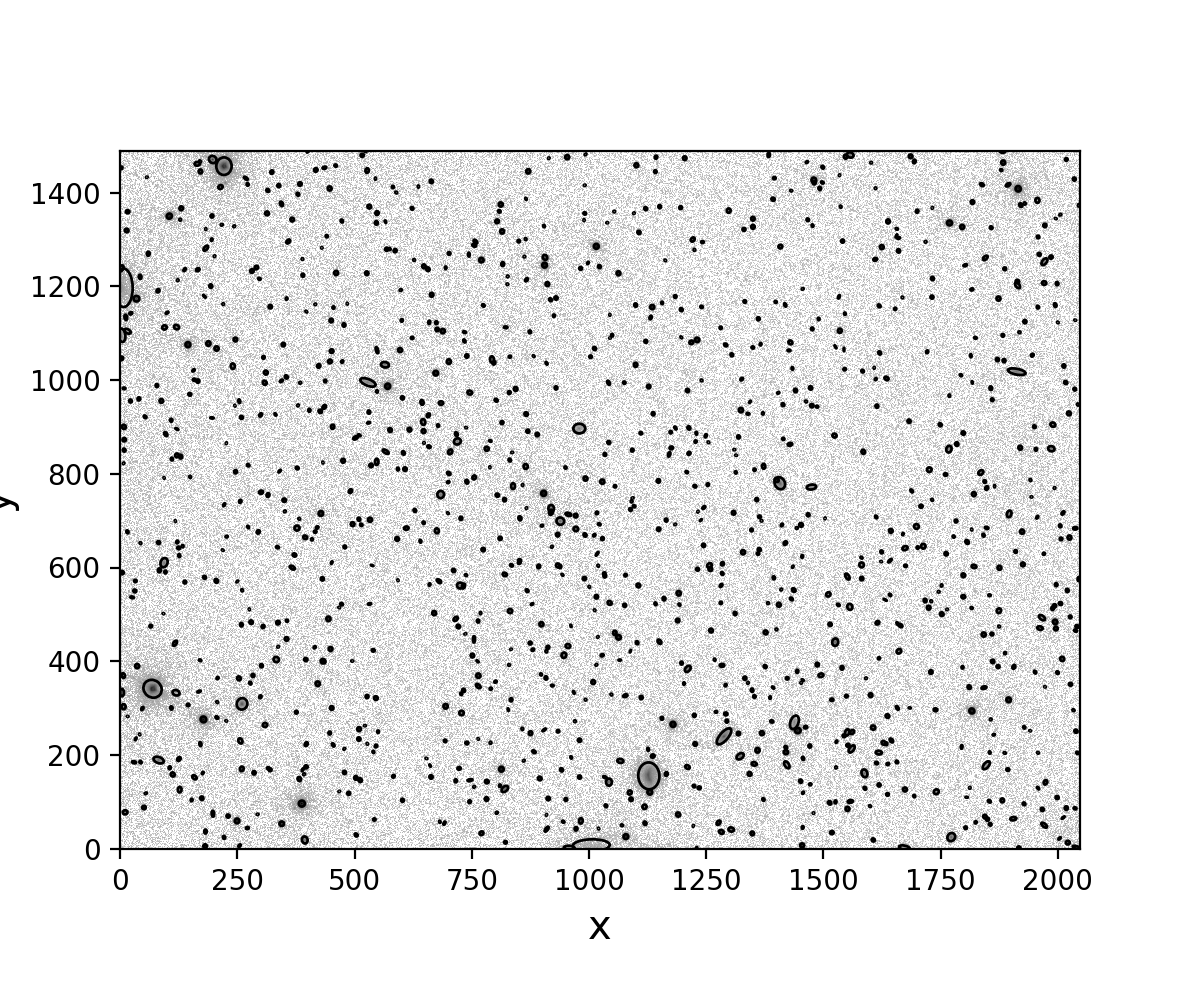

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/photometry.py:1277: RuntimeWarning: invalid value encountered in log10
  x = np.log10(valuetoshow) if logscale else valuetoshow


{'ax': <matplotlib.axes._axes.Axes at 0x182662a940>,
 'figure': <matplotlib.figure.Figure at 0x1825ecdc50>,
 'imshow': <matplotlib.image.AxesImage at 0x182662a898>,
 'prop': {'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1127e32b0>,
  'interpolation': 'nearest',
  'origin': 'lower'},
 'target_plot': None}

In [106]:
sdss.show(show_sepobjects=True)

In [107]:
ra,dec = sdss.wcs.central_coords
diag_size = sdss.wcs.diag_size

In [108]:
coord = SkyCoord(ra=ra,dec=dec, unit=(units.degree,units.degree))

In [109]:
angle = Angle(diag_size*1.4,"degree")

In [110]:
v = vizier.Vizier(column_filters={"rmag":"5..20"})
v.ROW_LIMIT = -1
t = v.query_region(coord,radius=angle,catalog="V/147", ).values()[0]

In [111]:
from astrobject.instruments.catalogues import SDSSCatalogue
sdsscat = SDSSCatalogue(None)
sdsscat.create(t, None, key_class="class",value_star=6,key_id="objID",
               key_ra="RA_ICRS",key_dec="DE_ICRS")

In [112]:
sdss.set_catalogue(sdsscat)

<IPython.core.display.Javascript object>


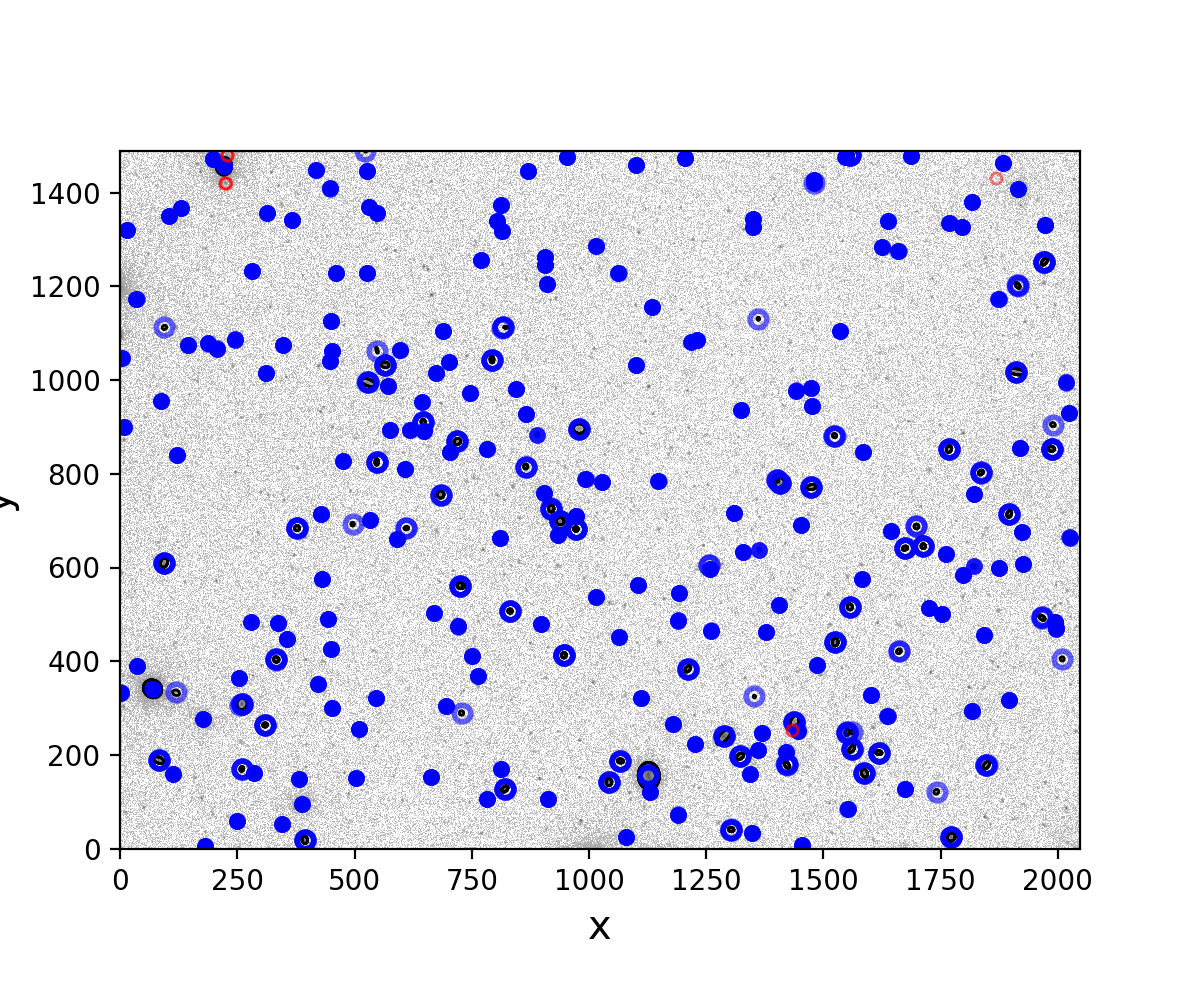

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/photometry.py:1277: RuntimeWarning: invalid value encountered in log10
  x = np.log10(valuetoshow) if logscale else valuetoshow


{'ax': <matplotlib.axes._axes.Axes at 0x1824a74f60>,
 'figure': <matplotlib.figure.Figure at 0x1825ecd128>,
 'imshow': <matplotlib.image.AxesImage at 0x1824a714a8>,
 'prop': {'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x1127e32b0>,
  'interpolation': 'nearest',
  'origin': 'lower'},
 'target_plot': None}

In [113]:
sdss.show(show_sepobjects=True, show_catalogue=True)

In [117]:
sdss.catalogue.define_around(5*units.arcsecond)
mask_stars = sdss.catalogue.get_mask(stars_only=True, isolated_only=False)

In [118]:
catindex = [i for i in range(len(sdss.catalogue.ra)) if mask_stars[i] and i in sdss.sepobjects.catmatch["idx_catalogue"]]
sepindex = sdss.sepobjects.catindex_to_index(catindex)

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/collections/photospatial.py:534: UserWarning: At least one catalogue entry has several index matched. First used  


In [119]:
sdss.sepobjects.get("x",[sepindex[4]]),sdss.sepobjects.get("y",[sepindex[4]])

(array([1349.61824325]), array([1344.05906317]))

In [120]:
ppoints = [sdss.get_photopoint(sdss.sepobjects.get("x",[i_])[0],
                               sdss.sepobjects.get("y",[i_])[0], 
                               3*sdss.sepobjects.get("a",[i_])[0])
         for i_ in sepindex]

In [121]:
p0 = ppoints[0]

In [122]:
p0.mag

17.281205565843166

In [123]:
from astrobject.utils.tools import flux_to_mag

In [124]:
mags = np.asarray([p0.mag for p0 in ppoints])

In [125]:
mags_ref = sdss.catalogue.mag[catindex]

<IPython.core.display.Javascript object>


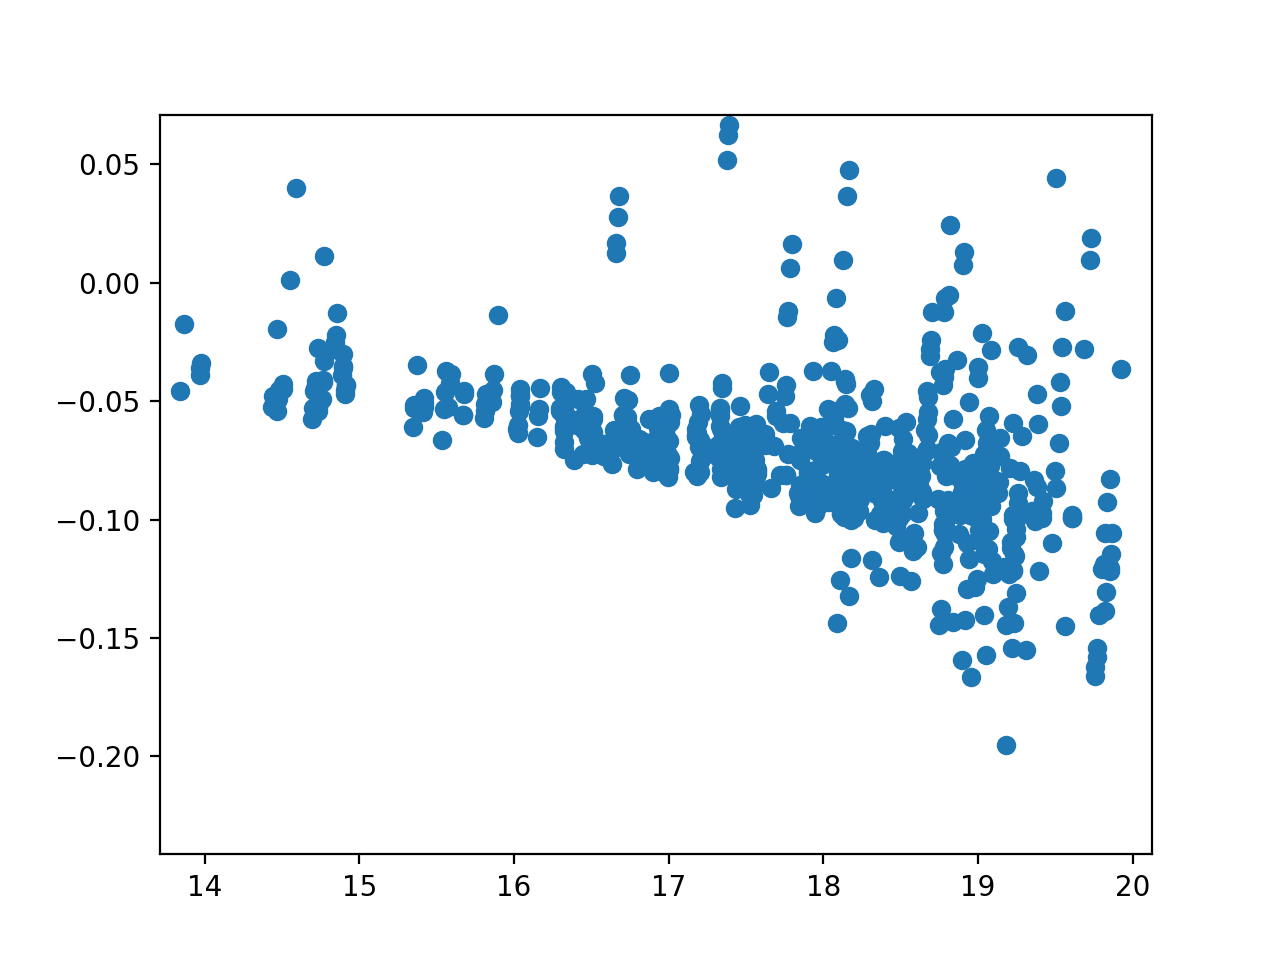

In [126]:
fig = mpl.figure()
ax  = fig.add_subplot(111)
ax.scatter(mags_ref, mags_ref-mags)

In [127]:
p0.lbda

7506.207753315575

In [62]:
import snfhost

In [17]:
sdss.set_catalogue(sdsscat, fast_setup=True)

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/photometry.py:2168: UserWarning: No instance or meta key list(meta.keys()). NaN returned


ValueError: zero-dimensional arrays cannot be concatenated

<IPython.core.display.Javascript object>


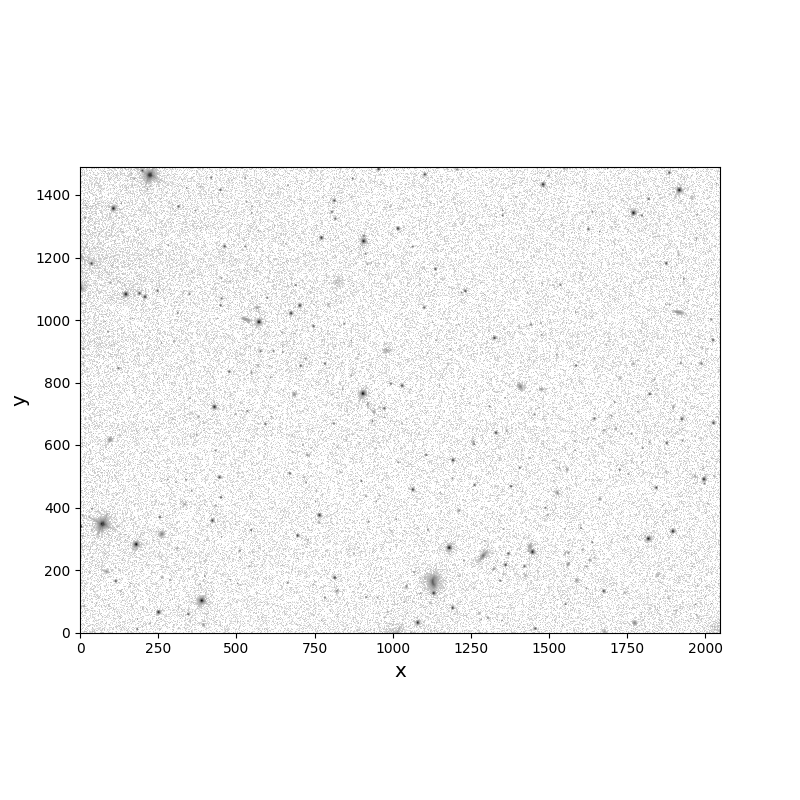

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/photometry.py:1277: RuntimeWarning: invalid value encountered in log10
  x = np.log10(valuetoshow) if logscale else valuetoshow


{'ax': <matplotlib.axes._axes.Axes at 0x18145bafd0>,
 'figure': <matplotlib.figure.Figure at 0x18145f3128>,
 'imshow': <matplotlib.image.AxesImage at 0x18145bacf8>,
 'prop': {'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x10402e1d0>,
  'interpolation': 'nearest',
  'origin': 'lower'},
 'target_plot': None}

In [20]:
sdss.show()

In [23]:
sdsscat.set_wcs(sdss.wcs, force_it=True)

<IPython.core.display.Javascript object>


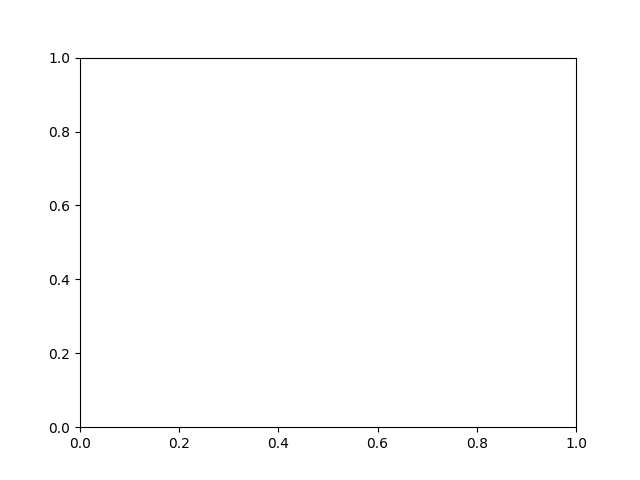

[]

In [30]:
fig = mpl.figure()
ax  = fig.add_subplot(111)

sdsscat.display(ax)

In [40]:
sdsscat.mag.data

masked_BaseColumn(data=[],
                  mask=[],
            fill_value=1e+20,
                 dtype=float32)

In [17]:
sdsscat.

'SDSS'

In [18]:
sdsscat.define_around(10*units.arcsec)

In [19]:
sdss.set_catalogue(sdsscat)

/Users/mrigault/anaconda3/lib/python3.6/site-packages/astrobject-0.5.15-py3.6.egg/astrobject/baseobject.py:990: UserWarning: WARNING No object in the field of view,
  -> catalogue not loaded


In [20]:
sdss.catalogue

In [22]:
sdss._side_properties

{'catalogue': None,
 'datamask': None,
 'exptime': 53.907456,
 'target': None,
 'wcs': WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN'  'DEC--TAN'  
 CRVAL : 256.826734959  35.4482984585  
 CRPIX : 1025.0  745.0  
 CD1_1 CD1_2  : 9.65240748628e-05  5.26838293781e-05  
 CD2_1 CD2_2  : 5.27097790727e-05  -9.65656379559e-05  
 NAXIS : 2048  1489}

In [45]:
sdss.sep_extract()

ValueError: zero-dimensional arrays cannot be concatenated

<IPython.core.display.Javascript object>


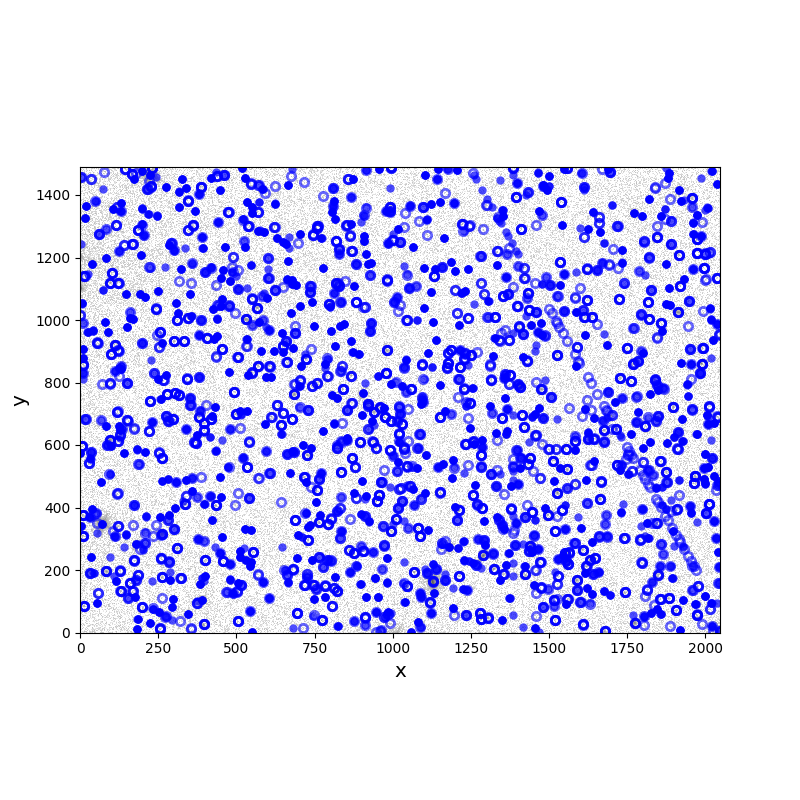

{'ax': <matplotlib.axes._axes.Axes at 0x1821f30240>,
 'figure': <matplotlib.figure.Figure at 0x1821f432e8>,
 'imshow': <matplotlib.image.AxesImage at 0x1822f43390>,
 'prop': {'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x110f2f390>,
  'interpolation': 'nearest',
  'origin': 'lower'},
 'target_plot': None}

In [39]:
sdss.show(show_catalogue=True)

In [5]:
sdss.download_catalogue(source="sdss",column_filters={"gmag":"13..22"},force_it=True) 

TypeError: '<' not supported between instances of 'str' and 'int'

You can now visualize the catalogue using the show() method

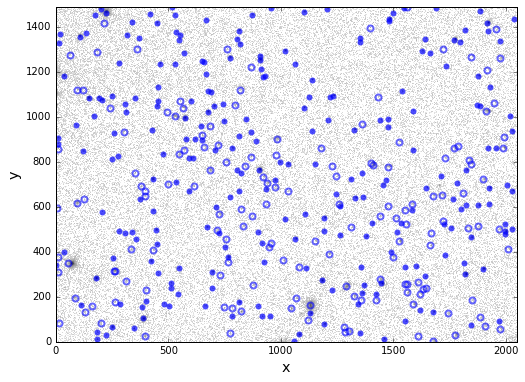

In [6]:
pl = sdss.show(show_catalogue=True)

**_Read the plot_** Full marker = stars / Open markers = non-stars (galaxies)

### Getting Gaia instead

Gaia only has stars

In [6]:
sdss.download_catalogue(source="gaia",force_it=True) 

TableParseError: Failed to parse VIZIER result! The raw response can be found in self.response, and the error in self.table_parse_error. The attempted parsed result is in self.parsed_result.
 Exception: None:35:4: W12: 'FIELD' element must have at least one of 'ID' or 'name' attributes

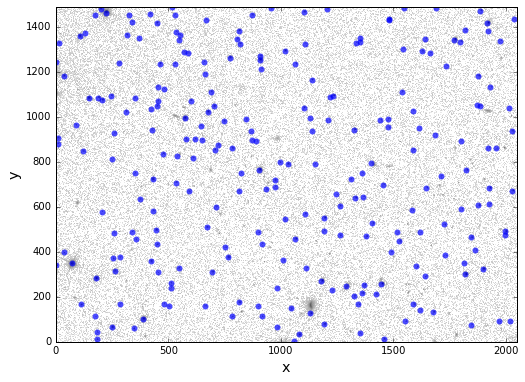

In [8]:
pl = sdss.show(show_catalogue=True)

## Let's switch back to sdss for now on

In [9]:
sdss.download_catalogue(source="sdss",column_filters={"gmag":"13..22"},
                        force_it=True) 

#### Extract the sources. 
Since the 'instrument' has a catalogue and a wcs solution, they are passed to the SexObject created (sepobjects).

**Remark** The order does not matter, if you first run sep_extract() and then load a catalogue, the catalogue will still be given to the sepobjects.

In [4]:
sdss.sep_extract()

Now than a catalogue and source extraction are associated to the image, detected sources and objects in the catalogue are matched. Let's first see what the show() methods show.

<IPython.core.display.Javascript object>


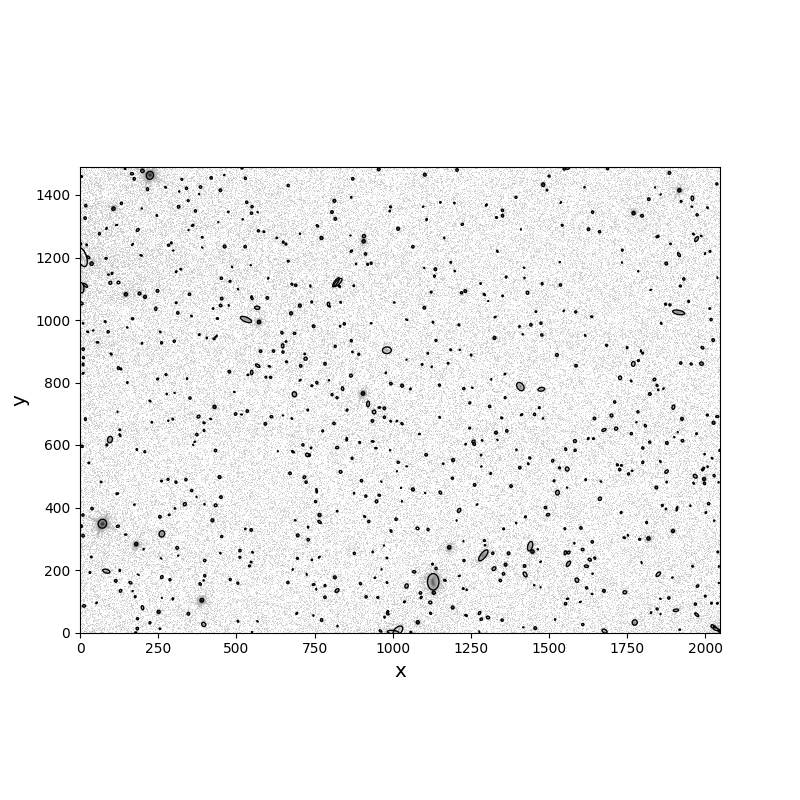

In [5]:
pl = sdss.show(show_sepobjects=True, show_catalogue=False)

**_Read the plot_** In red the objects in the catalogue with no source matched (too faint most likely). Open and filled marker show galaxies and stars respectively.

In [7]:
sdss.sepobjects.data

<Table length=743>
             id                     flux          var   ...   zp   zpsys
           str27                  float64       float64 ... object  str2
--------------------------- ------------------- ------- ... ------ -----
    177.98086870,0.42274717  0.4691810607910156     nan ...   None    ab
   1001.55306980,0.76624698   5.003009796142578     nan ...   None    ab
   1058.05095474,1.19558796     1.3621826171875     nan ...   None    ab
    549.90325716,1.54658368  0.2668180465698242     nan ...   None    ab
   1277.36174009,2.08259071 0.20119857788085938     nan ...   None    ab
   1678.03574989,4.47903543   7.209686279296875     nan ...   None    ab
    961.03657075,4.69366562  0.7891616821289062     nan ...   None    ab
   1016.69880899,5.18371435  13.541566848754883     nan ...   None    ab
   2044.48641432,5.46439292  1.2766189575195312     nan ...   None    ab
   1918.54657759,9.00794515    0.50372314453125     nan ...   None    ab
                        ...                 ...     ... ...    ...   ...
 166.05128703,1468.03642519  1.4584808349609375     nan ...   None    ab
1885.50120807,1470.70831943   43.78957748413086     nan ...   None    ab
 199.25270111,1477.21290472  104.58185577392578     nan ...   None    ab
1206.03305880,1480.02101125    15.0965576171875     nan ...   None    ab
 955.42621072,1482.12114509    99.3592758178711     nan ...   None    ab
1549.01230392,1483.24033394  3.0279769897460938     nan ...   None    ab
1687.89632177,1484.01263101     3.5384521484375     nan ...   None    ab
 143.55412034,1484.10696437  0.5016851425170898     nan ...   None    ab
 517.85346578,1485.99878994   1.888641357421875     nan ...   None    ab
1559.18040342,1486.10023910   4.886510848999023     nan ...   None    ab

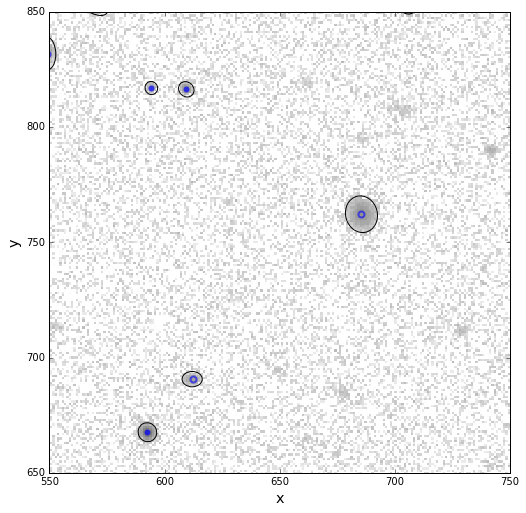

In [12]:
# lets zoom in
pl = sdss.show(zoomon=[650,750],show_sepobjects=True, 
               show_catalogue=True, zoom=100)

**_Read the plot_** Full marker = stars / Open markers = non-stars (galaxies) ; Red=non detected / Blue= detected

### Catalogue and Sepobjects

The information relating the catalogue object index to the sep onces are registered in the 'catmatch' dictionnary. You can check that the sepobjects has a catalogue and catalogue matching using the 'has_catalogue()' and 'has_catmatch()' methods.

In [13]:
sdss.sepobjects.catmatch

{'angsep': <Angle [  2.15987066e-05,  5.81640422e-05,  3.37818770e-05,
           2.97630446e-05,  3.41166982e-05,  1.84879697e-04,
           1.36225842e-05,  5.14889504e-05,  1.51727719e-05,
           3.20730222e-05,  2.17385745e-04,  4.12099436e-05,
           2.96823777e-05,  1.16618906e-05,  2.11838570e-05,
           2.68911744e-05,  5.81892540e-05,  2.96557347e-05,
           1.11412880e-05,  5.43419990e-05,  5.51319267e-04,
           5.53450137e-05,  2.80644660e-05,  2.07082833e-05,
           1.34810468e-05,  1.17806774e-05,  2.27115197e-05,
           3.46120476e-05,  1.11097751e-04,  4.03485431e-05,
           4.76022006e-05,  3.44975454e-05,  7.04217536e-06,
           4.89569420e-05,  1.89443695e-05,  5.68101161e-05,
           1.16104340e-05,  3.43762884e-05,  2.26372234e-05,
           3.44115261e-05,  2.59729283e-05,  2.77767058e-05,
           3.40780955e-05,  1.78170167e-05,  1.08876683e-05,
           2.30207639e-05,  3.16220800e-05,  4.62723034e-05,
           5.1

With a catalogue, you have access to additional information like stars mask; the catalogue knowing which object is a stars and which is not. This way you can use the "stars_only" input in a lot of methods.

**_Info masks_** The star mask is accessible though the 'starmask' array in the self function. Similarly, you have the "isolatedmask" that indicate the catalogue objects (all kinds) that do not have neighbour closer than 10arcsec. You can change this parameter using the "define_around" method of the catalogue instance.

** _Tip_** 'get_indexes()': This method enables to return the indexes of the detected sources that follow the following cuts: 

* isolated_only [False] get the indexes of the stars only
* stars_only [False] get the indexes of the isolated object only
* catmag_range [None,None] get the indexes of the object within the magnitudes ranges
* cat_indexes [False] Get the indexes of the calague object instead of the sextracted sources

In [32]:
import numpy as np
np.max(np.std(sdss.sepobjects.radec,axis=0)*5)

0.37082218228602326

In [25]:
sdss.wcs.diag_size

0.26739724912820545

In [14]:
print "The ellipse parameters x,y and theta for the detected stars"
from astropy.table import Table
mask = sdss.sepobjects.get_indexes(stars_only=True, isolated_only=False)
t_ = Table(data=[sdss.sepobjects.get("x",mask=mask),
                 sdss.sepobjects.get("y",mask=mask),
                 sdss.sepobjects.get("theta",mask=mask)],
          names=["x","y","theta"])
print t_
    

The ellipse parameters x,y and theta for the detected stars
      x             y            theta     
------------- ------------- ---------------
3.03489601132 340.078614825  -1.53724265099
182.912026585 12.4795196847  -1.33823871613
113.978412234 165.322063224  -1.56478106976
183.567629411  44.186652875   -1.1375784874
223.399212482 31.1352198361   1.34720647335
38.0716481251 396.385901817 -0.917294859886
251.127865568  66.219852814  -1.43333411217
 179.47459263  282.73481799   1.27616763115
346.256374528 60.0186418725  -1.04276895523
287.350737636 168.850363079  -1.51130068302
          ...           ...             ...
1819.83355435 1386.50794711  -1.21531105042
1923.08408392 1379.67448546 -0.627840280533
1885.50120807 1470.70831943  -1.48380231857
1917.39879622 1414.85850011   1.40817213058
1974.28512484 1336.45923349   -0.7439904809
2037.27305569  1435.5507513   1.02882540226
1456.37437181 13.9750062112  -1.03847932816
1553.24831525  91.873451968  -1.42972481251
1675.88316392 13

### Visualization of the detected source parameters

In addition to the 'diplay()' method, that enables to display the source ellipses in a axis (used by the image.show() method, two methods exists to visualize the source properties:

* show_ellipses: illustrate the source ellipses parameters
* show_hist: histogram of any parameters (any parameters accessible though the get())

**_Tip_**: the masking inputs (stars_only etc.) are arguments of the ploting functions.

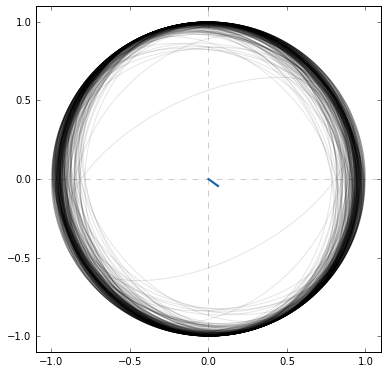

In [15]:
sdss.sepobjects.show_ellipses(stars_only=True, nonstars_only=False)

**_Read the plot_** All grey lines represent the shape of each detected source ellipses. The blue line (triangle in fact, but usually really thin if a lot of sources) is the typical PSF angle; the size is the ellipticity

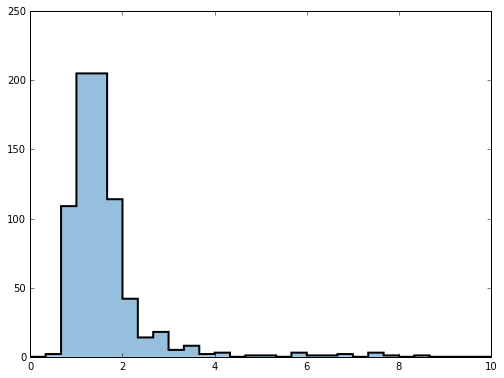

In [16]:
# show the distribution of any keyword
sdss.sepobjects.show_hist("a",bins=30, range=[0,10])

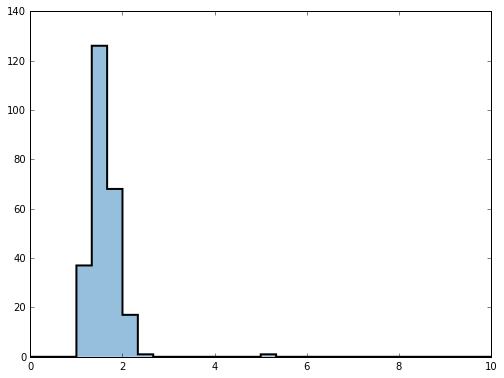

In [17]:
# - or just for the stars
sdss.sepobjects.show_hist("a",bins=30, range=[0,10], 
                          mask= sdss.sepobjects.get_indexes(stars_only=True))

# End
***